### Import Required Libraries

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [ ]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [ ]:
data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [ ]:
print(len(deu_eng))

deu_eng = deu_eng[:50000:]

249230


### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [ ]:
print(list(['Go.', 'Geh.', '']))
deu_eng

['Go.', 'Geh.', '']


array([list(['Go.', 'Geh.', '']), list(['Hi.', 'Hallo!', '']),
       list(['Hi.', 'Grüß Gott!', '']), ...,
       list(['Tom is still sitting.', 'Tom sitzt noch.', '']),
       list(['Tom is still smoking.', 'Tom raucht immer noch.', '']),
       list(['Tom is still talking.', 'Tom spricht noch.', ''])],
      dtype=object)

We will get rid of the punctuation marks, and then convert the text to lower case.

In [ ]:
# print(deu_eng[1])


# train_pos_no_punctuation = [remove_punctuation(i) for i in train_pos]
cleaned_deu_eng = []
for item in deu_eng:
  cleaned_item = [s.translate(str.maketrans('', '', string.punctuation)) for s in item]

  cleaned_item = [word.lower() for word in cleaned_item]

  #cleaned_item.pop(len(cleaned_item)-1)

  cleaned_deu_eng.append(cleaned_item)

from collections import Counter


cleaned_deu_eng = array(cleaned_deu_eng)
#Assign the first two elements of a list for all lists in cleaned_deu_eng
cleaned_deu_eng = cleaned_deu_eng[:, :2]
word_freq_dict = Counter(cleaned_deu_eng.flatten())
print(word_freq_dict.most_common()[0:10])
deu_eng = cleaned_deu_eng


[('go away', 37), ('yours is over there', 19), ('get away', 18), ('get lost', 18), ('beat it', 17), ('es geht mir gut', 12), ('just check it', 12), ('who removed it', 12), ('das stimmt nicht', 11), ('please hurry', 10)]


In [ ]:
print(deu_eng)
# print(deu_eng[:0])
# # Remove punctuation
# deu_eng[:0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng]
# deu_eng[:1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:1]]

[['go' 'geh']
 ['hi' 'hallo']
 ['hi' 'grüß gott']
 ...
 ['tom is still sitting' 'tom sitzt noch']
 ['tom is still smoking' 'tom raucht immer noch']
 ['tom is still talking' 'tom spricht noch']]


In [ ]:
print(deu_eng[1, 1])

hallo


In [ ]:
# # convert to lowercase
# print(len(deu_eng))


# for i in range(len(deu_eng)):
#     deu_eng[i][0].lower()
#     # print(deu_eng[i][0])
#     # break
#     deu_eng[i:,0] = deu_eng[i:,0].lower()
    
#     deu_eng[i:,1] = deu_eng[i:,1].lower()

# # deu_eng[0]

In [ ]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['tom is still sitting', 'tom sitzt noch'],
       ['tom is still smoking', 'tom raucht immer noch'],
       ['tom is still talking', 'tom spricht noch']], dtype='<U118')

In [ ]:
# !rm -r '/content/model.h1.24_jan_19'

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

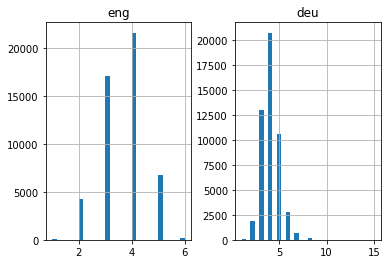

In [ ]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6123


In [ ]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10081


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['tom is still sitting', 'tom sitzt noch'],
       ['tom is still smoking', 'tom raucht immer noch'],
       ['tom is still talking', 'tom spricht noch']], dtype='<U118')

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [ ]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.3486
Epoch 1: val_loss improved from inf to 2.76400, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 35s 441ms/step - loss: 3.3486 - val_loss: 2.7640
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.6995
Epoch 2: val_loss improved from 2.76400 to 2.67305, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 387ms/step - loss: 2.6995 - val_loss: 2.6731
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.5441
Epoch 3: val_loss improved from 2.67305 to 2.49890, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 25s 408ms/step - loss: 2.5441 - val_loss: 2.4989
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.3716
Epoch 4: val_loss improved from 2.49890 to 2.36626, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 382ms/step - loss: 2.3716 - val_loss: 2.3663
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.2239
Epoch 5: val_loss improved from 2.36626 to 2.25902, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 25s 405ms/step - loss: 2.2239 - val_loss: 2.2590
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 2.0810
Epoch 6: val_loss improved from 2.25902 to 2.13261, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 25s 399ms/step - loss: 2.0810 - val_loss: 2.1326
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 1.9445
Epoch 7: val_loss improved from 2.13261 to 2.02768, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 25s 405ms/step - loss: 1.9445 - val_loss: 2.0277
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 1.8228
Epoch 8: val_loss improved from 2.02768 to 1.97964, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 25s 400ms/step - loss: 1.8228 - val_loss: 1.9796
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 1.7114
Epoch 9: val_loss improved from 1.97964 to 1.89124, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 387ms/step - loss: 1.7114 - val_loss: 1.8912
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 1.6081
Epoch 10: val_loss improved from 1.89124 to 1.80025, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 385ms/step - loss: 1.6081 - val_loss: 1.8003
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 1.5095
Epoch 11: val_loss improved from 1.80025 to 1.73034, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 26s 415ms/step - loss: 1.5095 - val_loss: 1.7303
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 1.4178
Epoch 12: val_loss improved from 1.73034 to 1.67970, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 381ms/step - loss: 1.4178 - val_loss: 1.6797
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.3276
Epoch 13: val_loss improved from 1.67970 to 1.63060, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 25s 402ms/step - loss: 1.3276 - val_loss: 1.6306
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 1.2451
Epoch 14: val_loss improved from 1.63060 to 1.56288, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 381ms/step - loss: 1.2451 - val_loss: 1.5629
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 1.1632
Epoch 15: val_loss improved from 1.56288 to 1.53851, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 25s 396ms/step - loss: 1.1632 - val_loss: 1.5385
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 1.0895
Epoch 16: val_loss improved from 1.53851 to 1.48660, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 23s 374ms/step - loss: 1.0895 - val_loss: 1.4866
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 1.0177
Epoch 17: val_loss improved from 1.48660 to 1.46559, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 393ms/step - loss: 1.0177 - val_loss: 1.4656
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 0.9494
Epoch 18: val_loss improved from 1.46559 to 1.43405, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 23s 369ms/step - loss: 0.9494 - val_loss: 1.4340
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 0.8826
Epoch 19: val_loss improved from 1.43405 to 1.39405, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 393ms/step - loss: 0.8826 - val_loss: 1.3941
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 0.8214
Epoch 20: val_loss improved from 1.39405 to 1.36514, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 23s 370ms/step - loss: 0.8214 - val_loss: 1.3651
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 0.7615
Epoch 21: val_loss improved from 1.36514 to 1.35121, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 388ms/step - loss: 0.7615 - val_loss: 1.3512
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.7045
Epoch 22: val_loss improved from 1.35121 to 1.32726, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 23s 369ms/step - loss: 0.7045 - val_loss: 1.3273
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.6522
Epoch 23: val_loss improved from 1.32726 to 1.30699, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 390ms/step - loss: 0.6522 - val_loss: 1.3070
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.6018
Epoch 24: val_loss improved from 1.30699 to 1.29085, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 23s 368ms/step - loss: 0.6018 - val_loss: 1.2909
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.5531
Epoch 25: val_loss improved from 1.29085 to 1.29059, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 389ms/step - loss: 0.5531 - val_loss: 1.2906
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.5096
Epoch 26: val_loss improved from 1.29059 to 1.27071, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 23s 367ms/step - loss: 0.5096 - val_loss: 1.2707
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.4686
Epoch 27: val_loss improved from 1.27071 to 1.26095, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 391ms/step - loss: 0.4686 - val_loss: 1.2610
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.4284
Epoch 28: val_loss improved from 1.26095 to 1.25692, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 23s 366ms/step - loss: 0.4284 - val_loss: 1.2569
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.3925
Epoch 29: val_loss improved from 1.25692 to 1.24217, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 24s 388ms/step - loss: 0.3925 - val_loss: 1.2422
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.3595
Epoch 30: val_loss did not improve from 1.24217
63/63 [==============================] - 7s 114ms/step - loss: 0.3595 - val_loss: 1.2535


Let's compare the training loss and the validation loss.

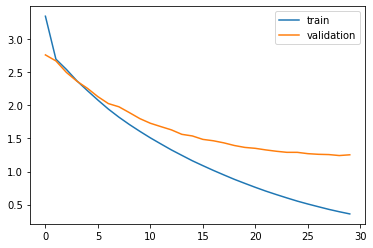

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [ ]:
model = load_model('model.h1.24_jan_19')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
# type (preds[:2])
# preds.shape
# preds[0].shape

# preds[0][0]

# len(preds[0])

# for j in range(len(preds[0])):
#   print(preds[0][j])


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
          if index == (n).any():
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []

for i in preds:
    
    temp = []

    for j in range(len(i)):
        
        
        any_1 = i[j]

        t = get_word(any_1, eng_tokenizer)
        if j > 0:
            any_2 = i[:,j-1]

            if (t == get_word(any_2, eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
# pred_df.head(15)

# print 15 rows randomly
pred_df.sample(len(testY))


,actual,predicted
6423,chill out,tom
2998,go away,tom
1260,bring me my clothes,tom
5275,im not from boston,tom
5120,did tom send you,tom
...,...,...
2929,dont touch my stuff,tom
2860,lets begin,tom
1106,i wouldve said no,tom
342,who is it,tom


In [ ]:
pred_df.actual.nunique()

9347

In [ ]:
pred_df.tail(15)

,actual,predicted
9985,i have a blue car,tom
9986,tom loves pasta,tom
9987,we are who we are,tom
9988,is that mouse dead,tom
9989,youre ambitious,tom
9990,is somebody there,tom
9991,did he touch you,tom
9992,tomll pay,tom
9993,do you have any gum,tom
9994,i like my house,tom


In [ ]:
pred_df.sample(15)

,actual,predicted
7862,birds fly,tom
7845,come home soon,tom
430,write it in pencil,tom
7488,its rush hour,tom
894,fishing is fun,tom
7192,the cat is black,tom
7731,i bought a red tie,tom
8875,ill give tom that,tom
4043,take it easy,tom
5970,has tom gone home,tom
